# Facial Landmark Detection - Intro to Deep Learning

### Import and Augment Data

In [1]:
# General imports
import pandas as pd
import numpy as np
import torch
from PIL import Image

#### Download & Import Data

In [2]:
# Download data from GitHub
!pip install wget -qU
import wget
import os.path

if not os.path.isfile("./facial-keypoints-detection.zip"):
    url = r"https://github.com/ko-redtruck/facial-landmark-detection/raw/main/facial-keypoints-detection.zip"
    wget.download(url, ".")

In [3]:
# Read training data
import zipfile

DATA_DIR = "./data"

def load_data_and_filter_from(file: str):
    data = pd.read_csv(f'{DATA_DIR}/{file}')
    data = data.dropna()
    return data

with zipfile.ZipFile("./facial-keypoints-detection.zip", 'r') as zip_ref:
    zip_ref.extractall("data")

training_data = load_data_and_filter_from('training.zip')
# training_data

In [59]:
# Convert data to numpy arrays

def convert_to_numpy(data: pd.DataFrame):
    X = [np.fromstring(image, dtype=np.uint8, sep=' ').reshape(96,96) for image in data["Image"]]
    X = np.reshape(X,(-1,96, 96))

    Y = np.delete(data.values,30,axis=1)
    Y = Y.reshape(-1,30).astype('float32')
    return X,Y

np_images, labels = convert_to_numpy(training_data)
np_images.shape, labels.shape

((2140, 96, 96), (2140, 30))

In [60]:
# Plot images
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

def plot_image(image: Image, labeling: np.ndarray=None):
    try:
        image = to_pil_image(image)
    except TypeError:
        pass
    plt.imshow(image, interpolation='nearest', cmap='gray')
    
    if labeling is not None:
        print(len(labeling))
        for i in range(0, len(labeling)-1, 2):
            plt.plot(labeling[i + 0],labeling[i + 1], marker=".", color='cyan')
    plt.show()

def plot_images(images: np.ndarray, labels: np.ndarray=None, num: int=None):
    for i in range(num if num is not None else len(images)):
        plot_image(images[i], None if labels is None else labels[i])

30


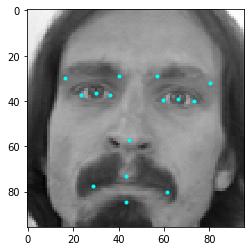

30


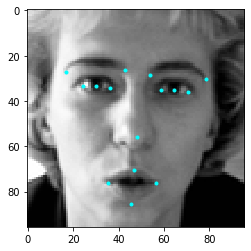

30


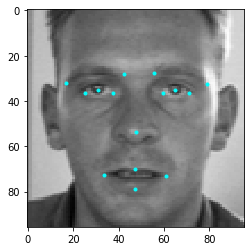

In [61]:
plot_images(np_images, labels, 3)

#### Image Preparation

In [7]:
# Transformation and augmentation of images
from torchvision import transforms
import torchvision.transforms.functional as tf
from numpy.random import randint, random

def transform_image(image: np.ndarray):
    transform = transforms.Compose([
        transforms.ColorJitter(0.5, 0.5, 0.5, 0.5),
        transforms.RandomErasing(scale=(0.01, 0.02))
    ])

    image = tf.to_tensor(image)
    image = tf.adjust_sharpness(image, 2 * random())
    return transform(image)

def random_resize_datapoint(image: torch.Tensor, labeling: np.ndarray):
    new_size = randint(image.shape[-1], 224, dtype='uint8')
    scaling = new_size / image.shape[-1]

    return tf.resize(image, [new_size, new_size]), labeling * scaling

def augment_data(images, label_list, size_factor: int=1):
    augmented_images = []
    augmented_labels = []

    for _ in range(size_factor):
        for i in range(len(images)):
            image = transform_image(images[i])
            image, labeling = random_resize_datapoint(image, label_list[i])

            augmented_images.append(image)
            augmented_labels.append(labeling)

    return augmented_images, augmented_labels

30


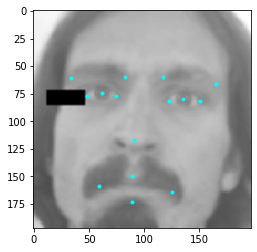

30


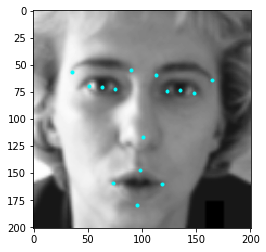

30


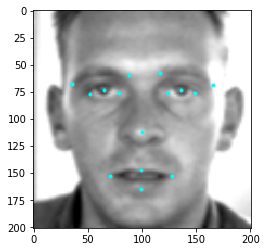

In [8]:
DATASET_AUGMENTATION_FACTOR = 2

augmented_images, augmented_labels = augment_data(np_images, labels, DATASET_AUGMENTATION_FACTOR)
plot_images(augmented_images, augmented_labels, 3)

In [49]:
# Padding images
from numpy.random import randint

def random_pad_image_with_noise(image: torch.Tensor, new_size: tuple[int, int], offset_x: int=0, offset_y: int=0):
    random_image = tf.to_tensor(randint(256, dtype='uint8', size=new_size))

    random_image[:, offset_y:image.shape[-2] + offset_y, offset_x:image.shape[-1] + offset_x] = image
    return random_image

def random_offset(image_dimensions, new_size: tuple[int, int]):
    min_offset = (0, 0)
    max_offset = np.subtract(new_size, image_dimensions)

    offset_y = randint(min_offset[0], max_offset[0])
    offset_x = randint(min_offset[1], max_offset[1])
    return offset_y, offset_x

def random_pad_datapoint(image: torch.Tensor, labeling: np.ndarray, new_size: tuple[int, int]):
    offset_y, offset_x = random_offset(image.shape[-2:], new_size)

    padded_image = random_pad_image_with_noise(image, new_size, offset_x=offset_x, offset_y=offset_y)
    adjusted_labeling = np.zeros(labeling.shape, dtype=labeling.dtype)
    adjusted_labeling[:-1:2] = labeling[:-1:2] + offset_x
    adjusted_labeling[1::2] = labeling[1::2] + offset_y

    return padded_image, adjusted_labeling

def random_pad_data(images, labels, new_size: tuple[int, int]):
    padded_images = []
    adjusted_labels = []

    for i in range(len(images)):
        image, labeling = random_pad_datapoint(image=images[i], labeling=labels[i], new_size=new_size)
        padded_images.append(image)
        adjusted_labels.append(labeling)

    return torch.stack(padded_images), adjusted_labels

NameError: ignored

30


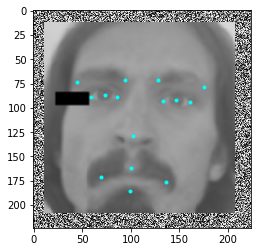

30


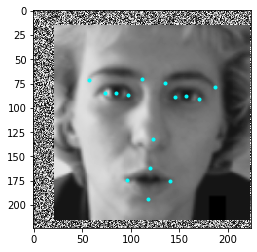

30


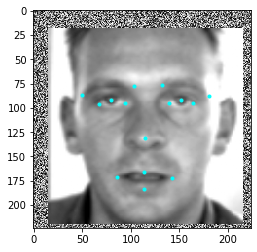

In [10]:
padded_images, final_labels = random_pad_data(augmented_images, augmented_labels, (224, 224))
plot_images(padded_images, final_labels, 3)

30


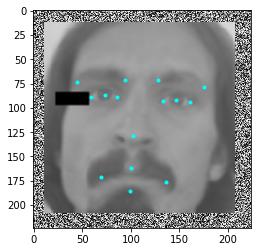

30


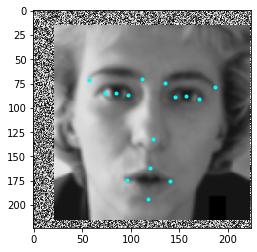

30


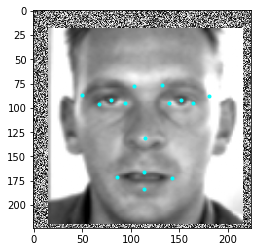

torch.Size([4280, 3, 224, 224])

In [11]:
# Transform images to RGB
final_images = torch.zeros((len(padded_images), 3, 224, 224))
final_images[:, :] = padded_images[:]

plot_images(final_images, final_labels, 3)
final_images.shape

### Training
#### Set up wandb & Cuda device

In [12]:
#Instantiating CUDA device
import torch

def device():
    return torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device()

device(type='cuda', index=0)

In [13]:
!pip install wandb -qU
import wandb

wandb.login()

wandb: Currently logged in as: leonardhorns. Use `wandb login --relogin` to force relogin


True

#### Define model and parameters for run

In [14]:
NET = "ResNet18"
FC_LAYER = "Lin-ReLu-Lin"
OPTIMIZER = "Adam"
LOSS = "MSE"
EPOCHS = 200
BATCH_SIZE = 400
LR = 0.001
MOMENTUM = 0.9 # SGD
WEIGHT_DECAY = 0.01

In [15]:
# Define parameter mappings
from torchvision.models import resnet18
from torch.optim import Adam
from torch import nn

def add_fc(net, layer):
    net.fc = layer
    return net

fc_layers = {
    "Lin-ReLu-Lin": nn.Sequential(
        nn.Linear(512,256),
        nn.ReLU(),
        nn.Linear(256,30)
    ),
    "Linear": nn.Linear(512, 30)
}

networks = {
    "ResNet18": add_fc(resnet18(pretrained=True), fc_layers[FC_LAYER])
}

optimizers = {
    "Adam": Adam(networks[NET].parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
}

loss_functions = {
    "MSE": nn.MSELoss()
}

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Set up Training

In [16]:
import sys

net = networks[NET].to(device())
optimizer = optimizers[OPTIMIZER]
loss_function = loss_functions[LOSS]
num_workers = 0 if sys.platform.startswith('win') else 2

In [17]:
# Define data loaders
from torch.utils.data import DataLoader, random_split

def get_data_loaders(images, labels, batch_size, test_data_split=0.1, num_workers=2):
    dataset = list(zip(images, labels))
    training_data_size = int(len(dataset) * (1-test_data_split))
    train, test = random_split(dataset, [training_data_size, len(dataset) - training_data_size])

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    test_loader = DataLoader(test, batch_size=batch_size, num_workers=num_workers)
    return train_loader,test_loader

In [18]:
train_loader, test_loader = get_data_loaders(final_images, final_labels, batch_size=BATCH_SIZE, test_data_split=0.15, num_workers=num_workers)

#### Training

In [19]:
# Define training and testing steps

def compute_loss(inputs, labels, net, loss_function):
    outputs = net(inputs.to(device()))
    labels = labels.to(device())

    return loss_function(outputs, labels)

In [20]:
# Init wandb tracking
wandb.init(project="facial-landmark-detection", entity="leo-team", config={"net": NET, "optimizer": OPTIMIZER, "final_layer": FC_LAYER, "epochs": EPOCHS, "batch_size": BATCH_SIZE, "lr": LR, "momentum": MOMENTUM, "weight decay" : WEIGHT_DECAY, "" : DATASET_AUGMENTATION_FACTOR})

for epoch in range(EPOCHS):  # loop over the dataset multiple times
    # train model
    train_loss = 0.
    net.train()
    for inputs, labels in train_loader:
        loss = compute_loss(inputs, labels, net, loss_function)
        train_loss += loss

        # optimize model
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    # average loss
    train_loss /= len(train_loader)
    
    # test model
    net.eval()
    with torch.no_grad():
      test_loss = 0.
      for inputs, labels in test_loader:
        test_loss += compute_loss(inputs, labels, net, loss_function)

      test_loss /= len(test_loader)
    
    # log error
    print('epoch {}, train loss {}, test loss {}'.format(epoch+1, train_loss, test_loss))
    wandb.log({
      "train_loss": train_loss,
      "test_loss": test_loss,
    })

wandb: Currently logged in as: leonardhorns (leo-team). Use `wandb login --relogin` to force relogin


epoch 1, train loss 12755.4892578125, test loss 9826.314453125
epoch 2, train loss 8928.2880859375, test loss 5418.197265625
epoch 3, train loss 3226.137939453125, test loss 1244.732666015625
epoch 4, train loss 843.7542114257812, test loss 538.0978393554688
epoch 5, train loss 402.828857421875, test loss 497.71826171875
epoch 6, train loss 357.36419677734375, test loss 315.7009582519531
epoch 7, train loss 339.5592346191406, test loss 284.018798828125
epoch 8, train loss 328.44720458984375, test loss 268.45166015625
epoch 9, train loss 303.81768798828125, test loss 255.5199432373047
epoch 10, train loss 292.126953125, test loss 241.734130859375
epoch 11, train loss 293.9443054199219, test loss 227.07424926757812
epoch 12, train loss 260.1795349121094, test loss 217.77041625976562
epoch 13, train loss 229.74119567871094, test loss 197.88140869140625
epoch 14, train loss 202.09567260742188, test loss 161.52859497070312
epoch 15, train loss 160.7320556640625, test loss 156.30328369140625

### Test Model

In [41]:
# Evaluate model on test data
from torchvision.transforms.functional import to_tensor

def plot_predictions_on_image(net, images, true_labels=None):
    try:
        inputs = to_tensor(images)
    except TypeError:
        inputs = images
        
    net.eval()
    with torch.no_grad():
      predicted_labels = net(inputs.to(device())).cpu()

    for i in range(len(images)):
        plt.scatter(predicted_labels[i][:-1:2], predicted_labels[i][1::2], marker=".", color='magenta')
        plot_image(images[i], None if labels is None else true_labels[i])

30


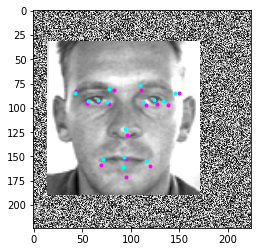

30


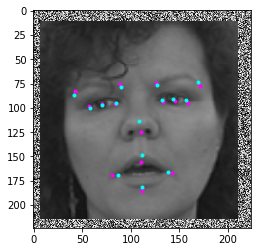

30


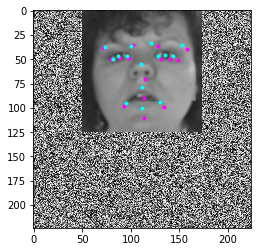

30


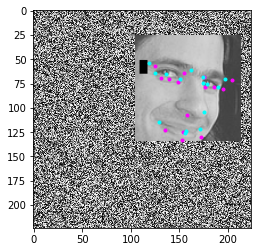

30


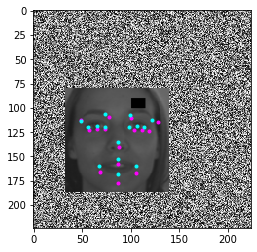

In [55]:
test_images, test_labels = next(iter(test_loader))

plot_predictions_on_image(net, test_images[0:5], test_labels[0:5])